In [75]:
from attention import AttentionLayer

In [76]:
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [77]:
data=pd.read_csv("input/amazon-fine-food-reviews/Reviews.csv",nrows=100000)

In [79]:
data.drop_duplicates(subset=['Text'],inplace=True)
data.dropna(axis=0,inplace=True)

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88421 entries, 0 to 99999
Data columns (total 10 columns):
Id                        88421 non-null int64
ProductId                 88421 non-null object
UserId                    88421 non-null object
ProfileName               88421 non-null object
HelpfulnessNumerator      88421 non-null int64
HelpfulnessDenominator    88421 non-null int64
Score                     88421 non-null int64
Time                      88421 non-null int64
Summary                   88421 non-null object
Text                      88421 non-null object
dtypes: int64(5), object(5)
memory usage: 7.4+ MB


In [6]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

In [81]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [82]:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0)) 

In [83]:
cleaned_text[:5]  

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [84]:
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [11]:
cleaned_summary[:10]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy',
 'nice taffy',
 'great just as good as the expensive brands',
 'wonderful tasty taffy',
 'yay barley',
 'healthy dog food']

In [85]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

In [86]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

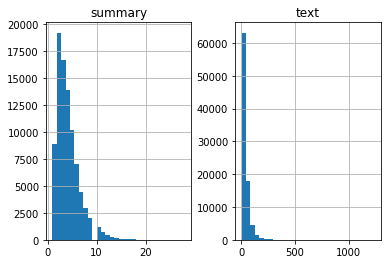

In [88]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [89]:
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=8):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9424907471335922


In [90]:
max_text_len=30
max_summary_len=8

In [91]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [92]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [18]:
df.to_csv('reviews_modified')

In [93]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['text']),np.array(df['summary']),test_size=0.1,random_state=0,shuffle=True) 

In [94]:
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences


In [95]:
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

## Alternative to get the entire vocabulary to UI

In [19]:
text = np.array(df['text'])
summary = np.array(df['summary'])
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(text))

In [96]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 66.12339930151339
Total Coverage of rare words: 2.953684513790566


In [97]:
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

x_voc   =  x_tokenizer.num_words + 1

In [98]:
x_voc

8440

## Again alternative for UI

In [21]:
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(text))

text_seq    =   x_tokenizer.texts_to_sequences(text) 

text = pad_sequences(text_seq,  maxlen=max_text_len, padding='post')

text_voc   =  x_tokenizer.num_words + 1

In [50]:
text_voc

8858

In [99]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

## UI

In [24]:
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(summary))

In [100]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 78.12740675541863
Total Coverage of rare words: 5.3921899389571895


In [101]:
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

y_voc  =   y_tokenizer.num_words +1

In [102]:
y_voc

1989

## UI

In [26]:
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(summary))

summary_seq    =   y_tokenizer.texts_to_sequences(summary) 

summary    =   pad_sequences(summary_seq, maxlen=max_summary_len, padding='post')

summary_voc  =   y_tokenizer.num_words +1

In [49]:
y_tokenizer.word_counts['sostok'],len(summary)   
summary_voc

2132

In [59]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

## UI

In [30]:
ind=[]
for i in range(len(summary)):
    cnt=0
    for j in summary[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

summary=np.delete(summary,ind, axis=0)
text=np.delete(text,ind, axis=0)

In [39]:
np.savetxt('texts.csv', text)
np.savetxt('summaries.csv', summary)

In [38]:
arr = np.loadtxt('texts.csv')
arr

array([[3.400e+01, 2.060e+02, 6.484e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [5.000e+00, 1.170e+02, 2.173e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.380e+02, 2.308e+03, 7.160e+02, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [4.000e+00, 1.500e+01, 2.190e+02, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [3.700e+01, 8.500e+01, 3.332e+03, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [3.000e+00, 3.690e+02, 3.870e+02, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

In [60]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)


In [61]:
X_test, y_test = x_val[:500], y_val[:500]
x_val, y_val = x_val[500:], y_val[500:]

## Alternative with convolutional encoder

In [62]:
from keras import backend as K
K.clear_session()

latent_dim = 300
embedding_dim=100

encoder_inputs = Input(shape=(max_text_len,))

enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

enc_conv1 = Conv1D(16, 7, activation='relu')(enc_emb)

enc_pool1 = MaxPooling1D(3)(enc_conv1)

enc_conv2 = Conv1D(16, 7, activation='relu')(enc_pool1)

# enc_pool2 = MaxPooling1D(3)(enc_conv2)

encoder_lstm3= LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(enc_conv2)

decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
                                                                                    
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state  = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      844000      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 24, 16)       11216       embedding[0][0]                  
________________________________________________________

In [33]:
from keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

encoder_inputs = Input(shape=(max_text_len,))

enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

encoder_lstm1 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4))
encoder_output1, state_h1, state_c1, state_h11, state_c11 = encoder_lstm1(enc_emb)

encoder_lstm2 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4))
encoder_output2, state_h2, state_c2, state_h22, state_c22 = encoder_lstm2(encoder_output1)

encoder_lstm3=Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4))
encoder_outputs, state_h, state_c, state_hh, state_cc= encoder_lstm3(encoder_output2)

decoder_inputs = Input(shape=(None,))

dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
                                                                                    
decoder_lstm = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2))
decoder_outputs,decoder_fwd_state, decoder_back_state, decoder_fwd_state1, decoder_back_state1 = decoder_lstm(dec_emb,initial_state=[state_h, state_c, state_hh, state_cc])

attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary() 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 30, 100)      844000      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 30, 600), (N 962400      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [63]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [36]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [37]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 41346 samples, validate on 4088 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
41346/41346 [==============================] - 98s 2ms/sample - loss: 2.8829 - val_loss: 2.6051
Epoch 2/50
41346/41346 [==============================] - 93s 2ms/sample - loss: 2.5219 - val_loss: 2.4515
Epoch 3/50
41346/41346 [==============================] - 93s 2ms/sample - loss: 2.3904 - val_loss: 2.3947
Epoch 4/50
41346/41346 [==============================] - 93s 2ms/sample - loss: 2.2936 - val_loss: 2.2975
Epoch 5/50
41346/41346 [==============================] - 94s 2ms/sample - loss: 2.2216 - val_loss: 2.2577
Epoch 6/50
41346/41346 [==============================] - 92s 2ms/sample - loss: 2.1669 - val_loss: 2.2463
Epoch 7/50
41346/41346 [==============================] - 92s 2ms/sample - loss: 2.1219 - val_loss: 2.2172
Epoch 8/50
41346/41346 [==============================] - 92s 2ms/sample - loss: 2.0825 - val_loss: 2.2384
E

In [73]:
model.save_weights('convEncmodel')

In [64]:
model.load_weights('convEncmodel')

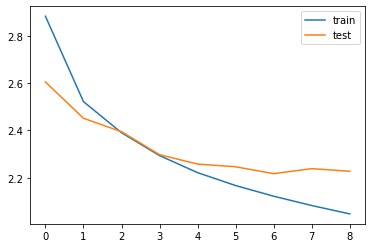

In [39]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [65]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [45]:
import json
fd = open('reverse_summary_word_index.json', 'w')
json.dump(reverse_target_word_index, fd)
fd.close()
fd = open('reverse_text_word_index.json', 'w')
json.dump(reverse_source_word_index, fd)
fd.close()
fd = open('summary_word_index.json', 'w')
json.dump(target_word_index, fd)
fd.close()

In [66]:
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
# decoder_state_input_hh = Input(shape=(latent_dim,))
# decoder_state_input_cc = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(2,latent_dim))

dec_emb2= dec_emb_layer(decoder_inputs) 
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

decoder_outputs2 = decoder_dense(decoder_inf_concat) 

decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [67]:
def decode_sequence(input_seq):

    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    target_seq = np.zeros((1,1))
    
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        e_h, e_c = h, c

    return decoded_sentence

In [68]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [69]:
for i in range(0,500):
    print("Review:",seq2text(X_test[i]))
    print("Original summary:",seq2summary(y_test[i]))
    print("Predicted summary:",decode_sequence(X_test[i].reshape(1,max_text_len)))
    print("\n")

Review: great healthy chew old beagle rio loves taste sure beats arm 
Original summary: yummy 
Predicted summary:  great


Review: thank goodness carbonated drink tasty without additives taste like cherry drinks slightly lighter flavoring although less half volume normal wonder things good comes small size least recycled 
Original summary: it is tasty 
Predicted summary:  great taste


Review: extra bold coffee one favorites extra bold could compared bold coffee regular coffee brewer 
Original summary: great coffee for keurig brewer 
Predicted summary:  great coffee


Review: like flavored coffee taste like coffee may could taste coffee travel size brew smaller brew sizes bit better 
Original summary: too much caramel cream not enough coffee 
Predicted summary:  coffee


Review: slightly overpriced one kitty last month less pound bags recently purchased petsmart dollars pound bag 
Original summary: great food 
Predicted summary:  great product


Review: boss likes smarties saw giant sm

Predicted summary:  great coffee


Review: meat flavor feel could little also slices thin burn quick dont pay attention cucumber sause place amazing though 
Original summary: not the best not the worst 
Predicted summary:  great


Review: hard find free gluten soy corn daughter eat shaped cereal find one yummier others better ingredients hard find stores happy see amazon happy buy pack 
Original summary: yummy 
Predicted summary:  best tasting snack


Review: product exceeds expectations tastes great raise blood sugar like regular refined pasta wish styles shapes pasta 
Original summary: mr 
Predicted summary:  good stuff


Review: great like coffee strong price fantastic compared department stores love cups 
Original summary: cannot beat the price 
Predicted summary:  great coffee


Review: really nice tea mango flavour subtle overpower green tea nice drink hot even better iced yum 
Original summary: delicious 
Predicted summary:  great tea


Review: days dog rolled couch onto floor c

Predicted summary:  great product


Review: boxes oz plus shipping stores 
Original summary: are you serious with this price 
Predicted summary:  good but not the best


Review: pop chips really good tasty healthy potato based horrible gluten free dang little starch eating regimen tasty made sick 
Original summary: really good but no more for me 
Predicted summary:  great tasting snack


Review: husband always cup big easy bold every morning quality consistent past several years ordered like dark roast without bitterness sometimes found dark roasts coffee 
Original summary: of the best dark roast coffees available 
Predicted summary:  great coffee


Review: great tasting jell without sweet natural tasting low calories well sugar content 
Original summary: without being too sweet 
Predicted summary:  great


Review: large boxes cereal great price husband eating cereal box per box loving taste lasting effect lunch happy deal 
Original summary: raisin bran cereal 
Predicted summary:  grea

Predicted summary:  not what expected


Review: passion kitchen love people life preparing best compromise quality mustard powder modified cover satisfy tastes kitchen would complete without 
Original summary: serious kitchen must have 
Predicted summary:  great product


Review: frosted mini wheats mixed cinnamon life nice healthy taste like 
Original summary: love it 
Predicted summary:  great


Review: tastes great got fast ordered air popper sister loved much 
Original summary: popcorn 
Predicted summary:  great taste


Review: delicious crunchy substantial even puppy whenever nibble best snack could get hands could help hey cares organic apple 
Original summary: very healthy satisfying snack substitute 
Predicted summary:  best ever


Review: lot line research finally ordering chest christmas present daughter law wanted right thrilled opened mailing container saw fine wood high quality wonderful selection teas classy 
Original summary: just right 
Predicted summary:  great product

Predicted summary:  great product


Review: love get pet food way chef always store way order like 
Original summary: pet 
Predicted summary:  great product


Review: yr old month old mt dog think best treat 
Original summary: the girls love them 
Predicted summary:  great product


Review: gourmet coffee stuff disappointing based upon previous good reviews suspect coffee cups received may changed manufacturing wolfgang puck decaf received watery tasteless aroma brewing keurig never 
Original summary: tasteless and watery 
Predicted summary:  not the best


Review: previous review completely different seller sorry mistake organic popcorn previous bad results 
Original summary: organic popcorn 
Predicted summary:  not bad


Review: great product subtle flavors aromas delicate dishes smokey salts hearty cooking great product chef loves flavor experimenting kitchen cool product 
Original summary: fantastic for the chef 
Predicted summary:  great product


Review: chihuahua loves food alte

Predicted summary:  great tea


Review: maybe found right blend powder milk sweet 
Original summary: little too sweet 
Predicted summary:  great coffee


Review: purchase unsalted dry roasted peanuts company regular basis use making candies absolutely problems product shipments 
Original summary: purchase 
Predicted summary:  great product


Review: cookies tasty little gooey calorie count one cookie bit high 
Original summary: good taste high calorie 
Predicted summary:  great


Review: coffee crave house strong brew yet bitter yuban best ground coffee tasted yet 
Original summary: absolutely the best 
Predicted summary:  great coffee


Review: strong taste almost like licorice like put honey tea something similar flavor noticeably difficult even want use taste stays smooth consistency sugared time 
Original summary: strong taste 
Predicted summary:  great tea


Review: tried chocolates belgium fantastic like chocolates better also way highly recommended 
Original summary: fantastic c

Predicted summary:  great product


Review: gave birthday absolutely loved would definitely buy one great teething puppies 
Original summary: awesome 
Predicted summary:  great for training


Review: ener foods english muffins look good packaging something makes mushy bottom presents feel mouth husband got stomach aches buying 
Original summary: mushy english muffins 
Predicted summary:  great product


Review: price coffee pretty good like strong cup good job using months auto ship give try 
Original summary: great coffee 
Predicted summary:  great coffee


Review: first time kid korea tried others gold bears best years taste great remember price beat 
Original summary: gummi 
Predicted summary:  great tasting


Review: tea strange taste enjoyable buying flavor look elsewhere present tea cheap tasting 
Original summary: weird taste flavors 
Predicted summary:  great tea


Review: first try got hooked like tea used past better would anyone likes strong hot tea 
Original summary: great 

Predicted summary:  not as good as expected


Review: excellent product use tea coffee nice smooth enjoyable 
Original summary: raw honey 
Predicted summary:  great tea


Review: love peanut satay product truly terrible way resemble dish oily salty tastes lousy waste money brand 
Original summary: flavorless 
Predicted summary:  not the best


Review: thrilled get amazon prime shipping much less expensive paying grocery store per pack personally like turkey even better beef great low carb snack 
Original summary: these are fantastic 
Predicted summary:  good stuff


Review: cooked noodle soups using chicken soup base chicken soup turned little salty added noodles vegetables soup without adding extra salt still little salty add water make tasty 
Original summary: little salty 
Predicted summary:  not as good as expected


Review: really know say already said tea tastes great decaffeinated natural process fair trade organic could ask favorite green tea date 
Original summary: love this t

Predicted summary:  great tea


Review: texture whole wheat pasta try pasta good seal cannot go wrong serving grams net usable carbs much healthier body regular pasta check smile 
Original summary: carb pasta that tastes like regular pasta 
Predicted summary:  great tasting snack


Review: great product fresh meat thank healthy food cats need much protein dogs grain fillers cats love 
Original summary: cats love it 
Predicted summary:  great product


Review: syrup hardly natural claimed tastes terrible check ingredients decide natural sticking pure maple 
Original summary: not the real deal 
Predicted summary:  not bad


Review: probably one dog favorite treats takes hour get stick whole thing inside kong way last longer bit expensive buy time 
Original summary: my dog loves this treat 
Predicted summary:  great product


Review: ordered started belly fat cure diet think fantastic think ever eat choice pasta fantastic little years ago grandmother would make pasta sunday dinners eating

Predicted summary:  not as good as expected


Review: product dried prunes good newman raisins keep product stew make plump order 
Original summary: rocks 
Predicted summary:  good stuff


Review: bought someone loves hot sauces said truly hot plus packaging makes fun gift 
Original summary: hot gift 
Predicted summary:  not as good as expected


Review: cannot say enough products daughter throws back like nothing absolutely loves wish stage readily available 
Original summary: love 
Predicted summary:  good stuff


Review: grew kid germany love flavors taste natural think much better starburst 
Original summary: best flavor 
Predicted summary:  great product


Review: great chip low sodium high fiber nice mild balance saltiness perfectly crisp versatile super alone great salsa delicious cheese everyone serve loves surprised healthy nutritional facts check website 
Original summary: fabulous 
Predicted summary:  best tasting snack


Review: product tastes like regular peanut butter gre

Predicted summary:  good stuff


Review: great chai tea aromatic flavorful overpowering strong like 
Original summary: very tasty 
Predicted summary:  great tea


Review: ordered balsamic vinegar com usual delivered right away packaged wonderfully vinegar absolutely best ever 
Original summary: wonderful 
Predicted summary:  great product


Review: cacao delicious use smoothies milk banana strawberries agave nectar slight bitterness dark chocolate love 
Original summary: yummy 
Predicted summary:  great product


Review: pros cons product lets start pros eat get fat overall really think worth price plan ordering actually trying hit lb mark wish luck 
Original summary: gummi bear heaven 
Predicted summary:  great product


Review: personally tried tea bought teacher gift sons teacher mentioned trying flavor tea shop years searched hoped would winner loved 
Original summary: great for tea lovers 
Predicted summary:  great tea




In [71]:
np.savetxt('textTest.csv', X_test)

In [72]:
np.savetxt('summaryTest.csv', y_test)

In [70]:
print(model.evaluate([X_test,y_test[:,:-1]], y_test.reshape(y_test.shape[0],y_test.shape[1], 1)[:,1:], batch_size=128))

500/500 [==============================] - 1s 2ms/sample - loss: 2.1618
2.161849304199219
